In [13]:
import torch
torch.manual_seed(0)

In [14]:
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'mps'

## Dataset

In [54]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from torch.utils.data import Dataset

class Pedar_Dataset_static2dynamic(Dataset):
    def __init__(self, static_path: str, dynamic_path: str, sense_range: float = 600, dtype = torch.float32, transform = None, target_transform = None):
        self.pedar_static = pd.read_pickle(static_path)
        self.pedar_dynamic = pd.read_pickle(dynamic_path)
        self.index = self.pedar_static.index
        
        self.dtype = dtype
        self.sense_range = sense_range

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        # get corresponding static and dynamic pressure data
        # transform to torch tensor and divide by the sense range
        static_pressure = torch.from_numpy(self.pedar_static.loc[self.index[idx], :].values).type(self.dtype) / self.sense_range
        dynamic_pressure = torch.from_numpy(self.pedar_dynamic.loc[self.index[idx], :].values).type(self.dtype) / self.sense_range

        if self.transform:
            static_pressure = self.transform(static_pressure)
        if self.target_transform:
            dynamic_pressure = self.target_transform(dynamic_pressure)

        return static_pressure, dynamic_pressure
    
    def draw_heatmap(self, arr: np.array, l_mask_path: str = 'config/left_foot_mask.png', plot: bool = True, vmin: float = 0.0, vmax: float = 600.0):
        # load foot masks
        l_img = Image.open(l_mask_path)
        r_img = ImageOps.mirror(l_img)

        l_mask = np.array(l_img).astype(np.float64)
        r_mask = np.array(r_img).astype(np.float64)

        # detect pixels of area no.1~197 and store the corresponding indexes
        l_index = {}
        r_index = {}

        for n in range(0, 198):
            l_index[n] = np.where(l_mask == n + 1)
            r_index[n + 99] = np.where(r_mask == n + 1)

        # create left and right foot heatmap
        l_pedar = np.zeros(l_mask.shape)
        r_pedar = np.zeros(r_mask.shape)

        for idx, value in enumerate(arr):
            if idx <= 99:
                # filling left foot area
                l_pedar[l_index[idx]] = value * self.sense_range

            else:
                # filling right foot area
                r_pedar[r_index[idx]] = value * self.sense_range

        # plot heatmap
        if plot:
            fig, axs = plt.subplots(1, 2)
            
            im = axs[0].imshow(l_pedar, vmin=vmin, vmax=vmax)
            axs[0].set_title('left')
            axs[0].axis('off')
            fig.colorbar(im, ax=axs[0])

            im = axs[1].imshow(r_pedar, vmin=vmin, vmax=vmax)
            axs[1].set_title('right')
            axs[1].axis('off')
            fig.colorbar(im, ax=axs[1])

            plt.show()

dataset = Pedar_Dataset_static2dynamic(static_path='output/pedar_static.pkl', dynamic_path='output/pedar_dynamic.pkl')

## Dataset item check

In [55]:
len(dataset), dataset.index

(300,
 MultiIndex([(   'BF',  'S1'),
             (   'BF', 'S10'),
             (   'BF', 'S11'),
             (   'BF', 'S12'),
             (   'BF', 'S13'),
             (   'BF', 'S15'),
             (   'BF', 'S16'),
             (   'BF', 'S17'),
             (   'BF', 'S18'),
             (   'BF', 'S19'),
             ...
             ('Poron', 'S66'),
             ('Poron', 'S67'),
             ('Poron', 'S68'),
             ('Poron', 'S69'),
             ('Poron',  'S7'),
             ('Poron', 'S70'),
             ('Poron', 'S72'),
             ('Poron', 'S73'),
             ('Poron', 'S76'),
             ('Poron',  'S9')],
            names=['condition', 'subject'], length=300))

In [56]:
dataset[0]

(tensor([6.2924e-03, 9.6259e-03, 1.5414e-02, 1.5651e-02, 3.1875e-03, 6.9745e-03,
         3.5178e-02, 4.7206e-02, 4.6440e-02, 3.8962e-02, 2.4400e-02, 0.0000e+00,
         2.6969e-02, 6.2229e-02, 1.0468e-01, 7.7406e-02, 5.8048e-02, 3.8865e-02,
         1.8477e-02, 4.3848e-03, 3.3641e-02, 4.8474e-02, 4.9649e-02, 4.2662e-02,
         3.2025e-02, 1.0924e-02, 0.0000e+00, 1.1905e-02, 2.7969e-02, 4.4200e-02,
         4.7836e-02, 5.0005e-02, 2.6128e-02, 0.0000e+00, 4.7869e-04, 8.4922e-03,
         3.5789e-02, 6.4905e-02, 9.6282e-02, 6.1963e-02, 0.0000e+00, 1.2975e-03,
         1.1044e-02, 3.0465e-02, 5.0751e-02, 8.9682e-02, 5.2298e-02, 5.7147e-04,
         4.9227e-03, 6.5205e-03, 1.6741e-02, 2.6580e-02, 3.7870e-02, 2.2128e-02,
         1.2332e-03, 9.1678e-03, 7.7575e-03, 1.1921e-02, 1.8879e-02, 1.9622e-02,
         1.8109e-02, 9.4942e-03, 2.4395e-02, 1.3049e-02, 1.5704e-02, 2.4979e-02,
         2.8689e-02, 2.3088e-02, 3.8576e-02, 3.9864e-02, 3.6333e-02, 4.5929e-02,
         4.2513e-02, 5.1337e

('BF', 'S1')
static pressure


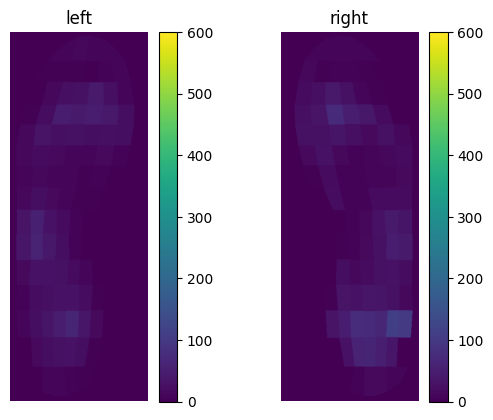

dynamic pressure


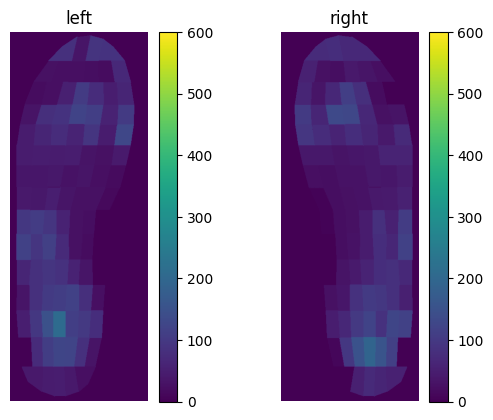

In [57]:
print(dataset.index[0])
print('static pressure')
dataset.draw_heatmap(dataset[0][0].detach().cpu().numpy())
print('dynamic pressure')
dataset.draw_heatmap(dataset[0][1].detach().cpu().numpy())

## Dataloader

In [58]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
len(train_dataset), len(test_dataset)

(240, 60)

In [59]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [60]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 198])
Labels batch shape: torch.Size([32, 198])


In [61]:
train_features.to(device)

tensor([[1.0792e-02, 4.9118e-02, 6.4341e-02,  ..., 2.3895e-05, 7.8139e-03,
         0.0000e+00],
        [8.5373e-04, 1.1285e-02, 2.4565e-02,  ..., 2.3691e-05, 1.3655e-02,
         0.0000e+00],
        [7.8987e-03, 3.8211e-02, 7.2764e-02,  ..., 3.5480e-02, 2.5184e-02,
         1.4954e-03],
        ...,
        [7.9976e-04, 1.0754e-02, 2.5509e-02,  ..., 0.0000e+00, 2.5767e-02,
         9.1381e-03],
        [2.7174e-03, 1.4268e-02, 2.6974e-02,  ..., 3.5273e-03, 6.2033e-03,
         0.0000e+00],
        [3.5592e-02, 6.4747e-02, 7.2454e-02,  ..., 1.1001e-02, 3.0219e-02,
         1.5543e-03]], device='mps:0')